[Ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification method for categories on an ordinal scale -- e.g. [1, 2, 3, 4, 5] or [G, PG, PG-13, R].  This notebook implements ordinal regression using the method of [Frank and Hal 2001](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), which transforms a k-multiLevel classifier into k-1 binary classifiers (each of which predicts whether a data point is above a threshold in the ordinal scale -- e.g., whether a movie is "higher" than PG).  This method can be used with any binary classification method that outputs probabilities; here L2-regularizaed binary logistic regression is used.

This notebook trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

In [1]:
!python -m nltk.downloader punkt

/Users/seanzhou/opt/anaconda3/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /Users/seanzhou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import sys
sys.path.append('..')

In [16]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from Utils import *

from sklearn.metrics import confusion_matrix

/Users/seanzhou/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/seanzhou/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [17]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y

In [18]:
class OrdinalClassifier:
    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            #print(text)
            feats = self.feature_method(text)
            featurized_data.append(feats)
        #print(featurized_data[0])
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1
        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
        #print(X)
        return X


    def train(self):
        (D,F) = self.trainX.shape
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 0.5, 1, 3, 5, 10, 20, 100]:
                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                # Lasso
                # log_reg = linear_model.LogisticRegression(C = C, penalty='l1',solver='liblinear', max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg

            self.log_regs[idx]=best_model
        
    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
            
        for data_point in range(len(preds[0])):
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

    def test_w_confusion(self):
        cor = tot = 0
        counts = Counter()
        preds = [None] * (len(self.ordinal_values) - 1)
        
        # Generate predictions for each ordinal regression model
        for idx, log_reg in enumerate(self.log_regs):
            preds[idx] = log_reg.predict_proba(self.testX)[:, 1]

        preds = np.array(preds)
        predictions = []
        true_labels = []

        # Generate predictions for each data point
        for data_point in range(len(preds[0])):
            ordinal_preds = np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values) - 1):
                if ordinal == 0:
                    ordinal_preds[ordinal] = 1 - preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal] = preds[ordinal - 1][data_point] - preds[ordinal][data_point]

            ordinal_preds[-1] = preds[-1][data_point]
            prediction = np.argmax(ordinal_preds)
            predictions.append(prediction)
            true_index = self.ordinal_values.index(self.orig_testY[data_point])
            true_labels.append(true_index)

            counts[prediction] += 1
            if prediction == true_index:
                cor += 1
            tot += 1

        self.predictions = predictions
        self.true_labels = true_labels
        return cor / tot

    def get_confusion_matrix(self):
        # Calculate the confusion matrix based on stored predictions and true labels
        if hasattr(self, 'predictions') and hasattr(self, 'true_labels'):
            return confusion_matrix(self.true_labels, self.predictions, labels=range(len(self.ordinal_values)))
        else:
            raise ValueError("Test method must be called before getting the confusion matrix.")


In [19]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [28]:
def run(trainingFile, devFile, testFile, ordinal_values):

    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    #comb_functions = [binary_bow_featurize, get_length]
    simple_classifier = OrdinalClassifier(ordinal_values, combiner_function, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    #accuracy=simple_classifier.test()
    accuracy=simple_classifier.test_w_confusion()
    conf_matrix = simple_classifier.get_confusion_matrix()
    print("Confusion Matrix on test set:\n")

    ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=['Level 1', 'Level 2', 'Level 3', 'Level 4'],
                    yticklabels=['Level 1', 'Level 2', 'Level 3', 'Level 4'])

    # Place the x-axis labels at the top
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()  # Move the x-axis ticks to the top
    plt.title('Confusion Matrix', y=1.2)  # Adjust title position
    plt.xlabel('Predicted Cognitive Level')
    plt.ylabel('True Cognitive Level')
    plt.show()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Confusion Matrix on test set:



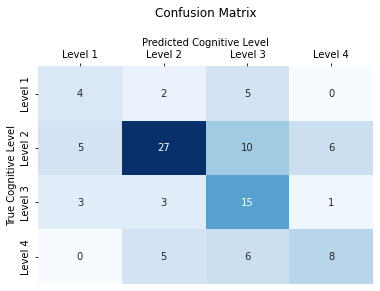

Test accuracy for best dev model: 0.540, 95% CIs: [0.442 0.638]



In [29]:
trainingFile = "../Data/train.txt"
devFile = "../Data/dev.txt"
testFile = "../Data/test.txt"
    
# ordinal values must be in order *as strings* from smallest to largest, e.g.:
# ordinal_values=["G", "PG", "PG-13", "R"]

ordinal_values=["1", "2", "3", "4"]

run(trainingFile, devFile, testFile, ordinal_values)